# PU-Net

In [ ]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro import poutine
from pyro.optim import Adam
from torch import nn
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

# --- Import Custom Modules ---
from scripts.data import get_loaders
from scripts.funcs import run_model
from scripts.funcs import print_losses
from scripts.simpleunet import SimpleUNet

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")

# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

### Define Dataloaders

In [14]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Model

In [ ]:
# Define convolutional block
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

# Define Encoder
class Encoder(nn.Module):                      
    def __init__(self, z_dim=64, init_ch=3):
        super().__init__()
        self.enc1 = double_conv(init_ch, 16)
        self.enc2 = double_conv(16, 32)
        self.enc3 = double_conv(32, 64)
        self.enc4 = double_conv(64, 128)
        self.to_stats = nn.Sequential(           
            nn.Conv2d(128, 2*z_dim, 1),
            nn.AdaptiveAvgPool2d(1))
         
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x5 = self.to_stats(x4).flatten(1)
        mu, log_sig = x5.chunk(2, dim=-1)

        return mu, torch.exp(0.5*log_sig)


# --- Define Decoder ---
class Conv1x1Decoder(nn.Module):
    def __init__(self, feat_ch=16, z_dim=64, hidden_ch=16, img_size=64):
        self.img_size = img_size
        super().__init__()
        in_ch = feat_ch + z_dim
        self.block = nn.Sequential(
            nn.Conv2d(in_ch,   hidden_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch,  hidden_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch,   hidden_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch,  hidden_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, 1, kernel_size=1))

    def forward(self, feats, z):
        B, _, _, _ = feats.shape

        # broadcast z to backbone shape
        z_map = z.view(B, -1, 1, 1).expand(B, z.size(1), self.img_size, self.img_size)
        x = torch.cat([feats, z_map], dim=1)
        return torch.sigmoid(self.block(x))
    
# Load the backbone model, which returns last convelutional layer - traditional UNet
backbone = SimpleUNet()

### Define PU-Net

In [ ]:
# --- Define VAE ---
class PU_NET(nn.Module):
    def __init__(self, z_dim=64, hidden_ch=16):
        self.output_dim = IMG_SIZE*IMG_SIZE
        super().__init__()

        # Define the encoder and decoder networks
        self.prior_net = Encoder(z_dim, init_ch=3)
        self.posterior_net = Encoder(z_dim, init_ch=4)
        self.backbone = backbone
        self.decoder = Conv1x1Decoder(feat_ch=16, z_dim=z_dim, hidden_ch=hidden_ch, img_size=IMG_SIZE)
        self.z_dim = z_dim

    def model(self, x, y=None):
        pyro.module("punet", self)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # Forward pass through the backbone to get last convolutional layer
            _, feats = self.backbone.forward(x)

            # Get prior distribution parameters
            prior_loc, prior_scale = self.prior_net.forward(x)

            # sample from prior
            z = pyro.sample("latent", dist.Normal(prior_loc, prior_scale).to_event(1))

            # Decode the latents and last convolutional layer features
            # to get the predicted output
            yhat = self.decoder.forward(feats, z)

            # If y is provided, use it as the observed variable
            if y is not None:
                pyro.sample("yhat", 
                        dist.Bernoulli(yhat, validate_args=False).to_event(3), 
                        obs=y)
                
            # If y is not provided, register yhat as a deterministic variable    
            else:
                pyro.deterministic('yhat', yhat.detach())

            return yhat

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y=None):
        # Register the model with Pyro
        pyro.module("punet", self)
        with pyro.plate("data", x.shape[0]):
            
            if y is None:
                # If y is not provided, use the prior network
                # to get the parameters of the prior distribution
                z_loc, z_scale = self.prior_net.forward(x)

            else:
                # If y is provided use the posterior network
                xy = torch.cat([x, y], dim=1)
                z_loc, z_scale = self.posterior_net.forward(xy)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [ ]:
# Test forward pass
model = PU_NET(z_dim=6, hidden_ch=16).to(device)
x = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
y = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(device)
yhat = model.model(x, y)
print("Output shape:", yhat.shape)

Output shape: torch.Size([1, 1, 64, 64])


### Define the ELBO loss with KL annealing

In [ ]:
# --- Define KL Annealing Loss ---
def elbo_kl_annealing(model, guide, x, y=None, latents_to_anneal=["latent"], beta=1.0):
    # get the annealing factor and latents to anneal from the keyword
    # arguments passed to the model and guide
    annealing_factor = beta
    latents_to_anneal = latents_to_anneal
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(
        guide).get_trace(x, y)
    
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(x, y)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [ ]:
# --- Training the CVAE ---
num_epochs = 300
test_frequency = 10
lr = 1e-4

pu_net = PU_NET(z_dim=64, hidden_ch=16).to(device)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(pu_net.model, pu_net.guide, optimizer, loss=elbo_kl_annealing)

pu_net = run_model(pu_net, svi, train_loader, test_loader, 
                 num_epochs=num_epochs, test_frequency=test_frequency, 
                 warmup_epochs=20, device=device)

[Epoch 1]
Mean training elbo: 2238.3825
Beta: 0.0000

[Epoch 2]
Mean training elbo: 12430372234.8544
Beta: 0.0500

[Epoch 3]
Mean training elbo: 638.8663
Beta: 0.1000

[Epoch 4]
Mean training elbo: 216.1562
Beta: 0.1500

[Epoch 5]
Mean training elbo: 171.8221
Beta: 0.2000

[Epoch 6]
Mean training elbo: 164.3073
Beta: 0.2500

[Epoch 7]
Mean training elbo: 158.6244
Beta: 0.3000

[Epoch 8]
Mean training elbo: 155.6599
Beta: 0.3500

[Epoch 9]
Mean training elbo: 151.6529
Beta: 0.4000

[Epoch 10]
Mean training elbo: 148.2737
Beta: 0.4500
Mean test loss: 175.7450

[Epoch 11]
Mean training elbo: 147.4645
Beta: 0.5000

[Epoch 12]
Mean training elbo: 142.5300
Beta: 0.5500

[Epoch 13]
Mean training elbo: 140.1828
Beta: 0.6000

[Epoch 14]
Mean training elbo: 138.1792
Beta: 0.6500

[Epoch 15]
Mean training elbo: 135.6251
Beta: 0.7000

[Epoch 16]
Mean training elbo: 133.7247
Beta: 0.7500

[Epoch 17]
Mean training elbo: 132.8286
Beta: 0.8000

[Epoch 18]
Mean training elbo: 128.8073
Beta: 0.8500

[Ep

In [ ]:
def predict(x):
    posterior_predictive = Predictive(pu_net.model, guide=pu_net.guide, num_samples=1)
    samples = posterior_predictive(x, None)
    pred = samples["yhat"]  
    pred = pred.squeeze(0) 
    return pred
    
# Model evaluation
pu_net.eval()
with torch.no_grad():
    print_losses(test_loader, pu_net, predict, device)

BCE loss:
0.01

Average DICE score:
0.86

ELBO loss:
36.62


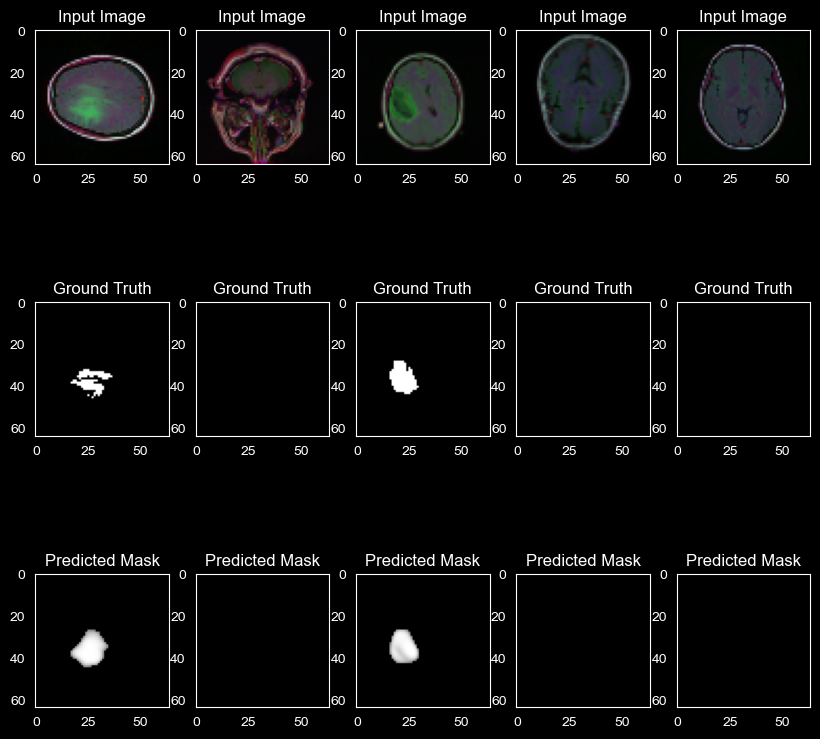

In [ ]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225] 
        labels = labels.to(device)
        with torch.no_grad():
            outputs = predict(images)
        outputs[outputs < 0.5] = 0
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow((images[i].transpose(1, 2, 0)*std + mean).clip(0, 1))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")

visualize_predictions(pu_net, test_loader)